In [1]:
#IMPORT STATEMENTS
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import csv
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
import copy
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score
import time

In [2]:
transform=transforms.Compose([
          transforms.Resize((224,224)),
          transforms.RandomResizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])


In [3]:
# Load datasets
train_set = ImageFolder(r'..\dataset\train', transform)
val_set = ImageFolder(r'..\dataset\val', transform)
test_set = ImageFolder(r'..\dataset\test', transform)

In [4]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


In [5]:
model = models.vgg19(pretrained=True)

d:\Projects\Rice Leaf Classification & Detection\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Projects\Rice Leaf Classification & Detection\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
from torchsummary import summary 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

summary(model, input_size=(3,244,244))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1,

In [7]:
print("Train classes:", train_set.classes)  # Make sure it's 2
print("Class indices:", train_set.class_to_idx)


Train classes: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
Class indices: {'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}


In [ ]:
num_features = model.classifier[6].in_features
num_classes = len(train_set.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {train_set.classes}")
features = list(model.classifier.children())[:-1]  # Remove the last layer
features.append(nn.Linear(num_features, num_classes))  # ✅ Use num_classes (3) instead of len(train_set)
model.classifier = nn.Sequential(*features)

print(f"\n✅ Modified VGG19 classifier:")
print(model.classifier)

# Move model to device after modification
model = model.to(device)
print(f"\nModel moved to device: {next(model.parameters()).device}")

Original VGG19 classifier:
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

Input features to final layer: 4096
Number of classes: 3
Classes: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

✅ Modified VGG19 classifier:
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)

Model moved to device: cuda:0


In [9]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))


CUDA available: True
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [10]:
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [11]:
print(next(model.parameters()).device)


cuda:0


In [12]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, num_classes):
    since = time.time()
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = 0

    # Initialize CSV logging
    csv_filename = 'training_log.csv'
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train Loss', 'Train Acc', 'Train Precision', 'Train Recall', 'Train F1',
                         'Val Loss', 'Val Acc', 'Val Precision', 'Val Recall', 'Val F1'])

    # Initialize metrics
    train_precision = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
    train_recall = MulticlassRecall(num_classes=num_classes, average='macro').to(device)
    train_f1 = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

    val_precision = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
    val_recall = MulticlassRecall(num_classes=num_classes, average='macro').to(device)
    val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        all_train_preds = []
        all_train_labels = []

        # Training loop
        for inputs, labels in train_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_train_preds.append(predicted)
            all_train_labels.append(labels)

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct / total
        all_train_preds = torch.cat(all_train_preds)
        all_train_labels = torch.cat(all_train_labels)

        # Compute Train Precision, Recall, F1
        train_precision_score = train_precision(all_train_preds, all_train_labels).item()
        train_recall_score = train_recall(all_train_preds, all_train_labels).item()
        train_f1_score = train_f1(all_train_preds, all_train_labels).item()

        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}, "
              f"Training Accuracy: {train_accuracy:.2f}%, "
              f"Train Precision: {train_precision_score:.4f}, Train Recall: {train_recall_score:.4f}, Train F1: {train_f1_score:.4f}")

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)

                val_corrects += (predicted == labels).sum().item()
                all_val_preds.append(predicted)
                all_val_labels.append(labels)

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * val_corrects / len(val_loader.dataset)

        all_val_preds = torch.cat(all_val_preds)
        all_val_labels = torch.cat(all_val_labels)

        # Compute Validation Precision, Recall, F1
        val_precision_score = val_precision(all_val_preds, all_val_labels).item()
        val_recall_score = val_recall(all_val_preds, all_val_labels).item()
        val_f1_score = val_f1(all_val_preds, all_val_labels).item()

        print(f"Epoch [{epoch+1}/{epochs}], Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}% | "
              f"Precision: {val_precision_score:.4f}, Recall: {val_recall_score:.4f}, F1: {val_f1_score:.4f}")

        # Append metrics to CSV
        with open(csv_filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch+1, avg_train_loss, train_accuracy, train_precision_score, train_recall_score, train_f1_score,
                             avg_val_loss, val_accuracy, val_precision_score, val_recall_score, val_f1_score])

        # Save the best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1

    elapsed_time = time.time() - since
    print(f"Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    torch.save(best_model_wts, f"best_model_epoch_{best_epoch}.pth")
    print(f"\n✔️ Best model saved at epoch {best_epoch} with {best_val_acc:.2f}% accuracy")
    
    model.load_state_dict(best_model_wts)
    return model


In [14]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, device=device, num_classes=3)

Epoch [1/100], Training Loss: 0.0438, Training Accuracy: 32.29%, Train Precision: 0.3232, Train Recall: 0.3229, Train F1: 0.3229
Epoch [1/100], Val Loss: 1.1067, Val Acc: 33.33% | Precision: 0.2222, Recall: 0.3333, F1: 0.2491
Epoch [2/100], Training Loss: 0.0605, Training Accuracy: 28.12%, Train Precision: 0.2804, Train Recall: 0.2812, Train F1: 0.2798
Epoch [2/100], Val Loss: 1.1135, Val Acc: 33.33% | Precision: 0.2222, Recall: 0.3333, F1: 0.2491
Epoch [3/100], Training Loss: 0.0413, Training Accuracy: 28.12%, Train Precision: 0.1875, Train Recall: 0.2812, Train F1: 0.2250
Epoch [3/100], Val Loss: 1.1056, Val Acc: 33.33% | Precision: 0.1111, Recall: 0.3333, F1: 0.1667
Epoch [4/100], Training Loss: 0.0350, Training Accuracy: 27.08%, Train Precision: 0.2495, Train Recall: 0.2708, Train F1: 0.2533
Epoch [4/100], Val Loss: 1.1098, Val Acc: 33.33% | Precision: 0.1111, Recall: 0.3333, F1: 0.1667
Epoch [5/100], Training Loss: 0.0358, Training Accuracy: 29.17%, Train Precision: 0.2573, Train 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
print(device)

cuda


In [16]:
def evaluate_model(model, dataloader, class_names):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    auc = roc_auc_score(y_true, y_probs, multi_class='ovr')

    return {
        "accuracy": report["accuracy"],
        "precision": np.mean([report[cls]["precision"] for cls in class_names]),
        "recall": np.mean([report[cls]["recall"] for cls in class_names]),
        "f1_score": np.mean([report[cls]["f1-score"] for cls in class_names]),
        "roc_auc": auc
    }


In [17]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ✅ Use a raw string or double backslashes to avoid escape character errors
test_dir = r"..\dataset\test"

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = test_dataset.classes
print("Classes:", class_names)


Classes: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


In [21]:
import torch
import torch.nn as nn
from torchvision import models

# ✅ Create VGG19 and modify it to match the saved model structure
vgg19 = models.vgg19(pretrained=True)

# Freeze earlier layers
for param in vgg19.parameters():
    param.requires_grad = False

# ✅ IMPORTANT: Modify VGG19 to have 3 output classes BEFORE loading weights
num_features = vgg19.classifier[6].in_features
num_classes = len(train_set.classes)  # Should be 3


# Replace the final layer to match the saved model
features = list(vgg19.classifier.children())[:-1]  # Remove the last layer
features.append(nn.Linear(num_features, num_classes))  # Add layer with 3 outputs
vgg19.classifier = nn.Sequential(*features)


# ✅ Model dict
models_dict = {
    "VGG19": vgg19  # Changed name to VGG19 for consistency
}

model_paths = {
    "VGG19": r"best_model_epoch_69.pth"
}

# ✅ Load weights and move to device
for name, current_model in models_dict.items():
    print(f"\nLoading weights for {name}...")
    try:
        current_model.load_state_dict(torch.load(model_paths[name], map_location=device))
        current_model.to(device)
        current_model.eval()
    except Exception as e:
        print(f"❌ [ERROR] Failed to load {name}: {e}")
        
        # Let's check the shapes in the saved model
        checkpoint = torch.load(model_paths[name], map_location='cpu')
        print(f"Saved model final layer shape: {checkpoint['classifier.6.weight'].shape}")
        print(f"Current model final layer shape: {current_model.classifier[6].weight.shape}")


Loading weights for VGG19...


C:\Users\altaf\AppData\Local\Temp\ipykernel_14756\49084149.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  current_model.load_state_dict(torch.load(model_paths[name], m

In [22]:
results = []

for name, model in models_dict.items():
    print(f"Evaluating {name}...")
    metrics = evaluate_model(model, test_loader, class_names)
    metrics["model"] = name
    results.append(metrics)

df_results = pd.DataFrame(results)
df_results = df_results[["model", "accuracy", "precision", "recall", "f1_score", "roc_auc"]]

Evaluating VGG19...


d:\Projects\Rice Leaf Classification & Detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Projects\Rice Leaf Classification & Detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Projects\Rice Leaf Classification & Detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

In [23]:
log_path = "model_evaluation_log.csv"
df_results.to_csv(log_path, index=False)
print(f"Saved evaluation results to: {log_path}")
df_results

Saved evaluation results to: model_evaluation_log.csv


,model,accuracy,precision,recall,f1_score,roc_auc
0,VGG19,0.416667,0.259259,0.416667,0.300366,0.729167


Gathering ROC data for VGG19...


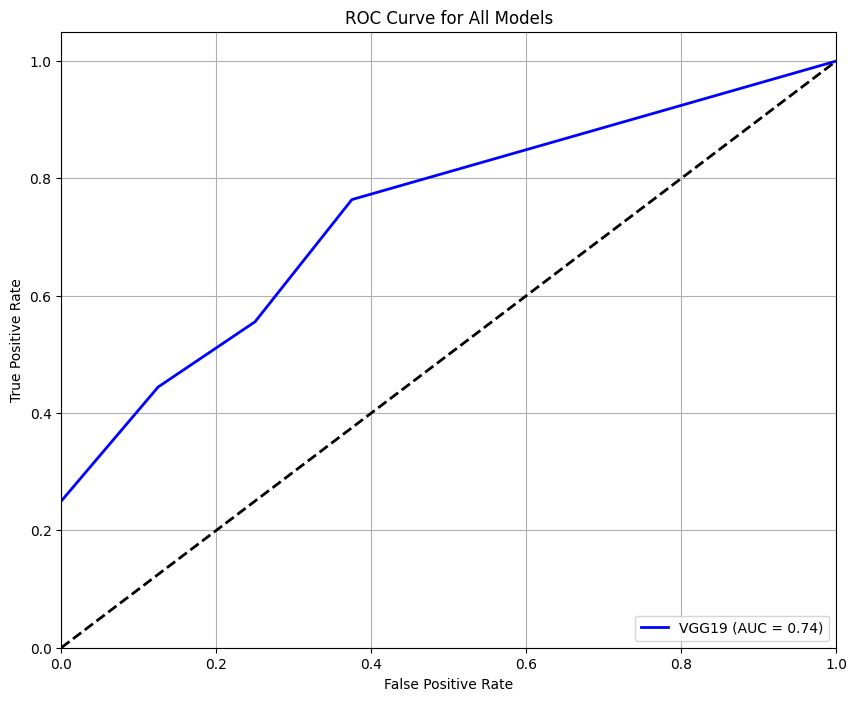

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


def get_predictions(model, dataloader, device):
    model.eval()
    y_true = []
    y_prob = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    return np.array(y_true), np.array(y_prob)

# Assuming you now collect this from evaluate_model per model
# Each model's true and predicted probabilities must be stored in a dictionary
roc_data = {}

for i, (name, model) in enumerate(models_dict.items()):
    print(f"Gathering ROC data for {name}...")
    y_true, y_prob = get_predictions(model, test_loader, device)
    roc_data[name] = (y_true, y_prob)

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple']

for i, (name, (y_true, y_prob)) in enumerate(roc_data.items()):
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for j in range(len(class_names)):
        fpr[j], tpr[j], _ = roc_curve(y_true_bin[:, j], y_prob[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Macro-average AUC
    all_fpr = np.unique(np.concatenate([fpr[j] for j in range(len(class_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    for j in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])
    mean_tpr /= len(class_names)

    macro_auc = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, color=colors[i], lw=2,
             label=f"{name} (AUC = {macro_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("roc_auc_comparison.png")
plt.show()


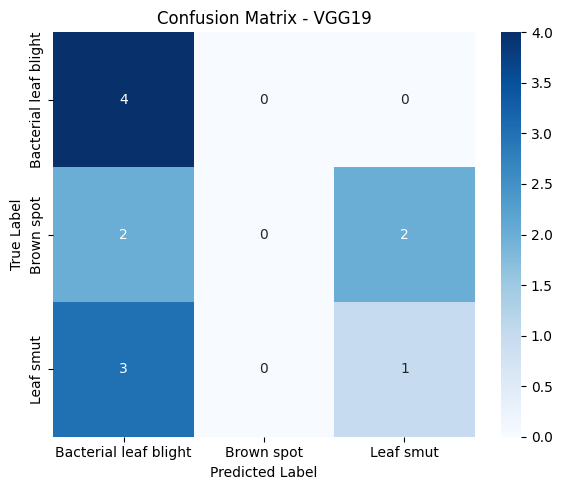

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Example class names
class_names = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

# Assuming y_true and y_prob are already defined for ResNet50
y_true, y_prob = roc_data["VGG19"]  # Get predictions and probabilities
y_pred = np.argmax(y_prob, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot 1x1 confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix - VGG19")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("resnet_confusion_matrix.png")
plt.show()
